In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
RAND = 115

In [2]:
import plotly.graph_objects as go
import plotly.express as px

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
from collections import Counter

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.ops.focal_loss as focal_loss
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [12]:
try:
    from torchsummary import summary
except:
    ! pip install torchsummary
    from torchsummary import summary

In [13]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
from transformers import AutoModel, AutoTokenizer, BertTokenizerFast
from transformers import AdamW

In [16]:
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"

In [17]:
full_data = pd.read_csv("/Users/shin/Desktop/mtsamples.csv")

In [18]:
full_data.sample(5)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
2504,2504,Laparoscopic-assisted vaginal hysterectomy. ...,Obstetrics / Gynecology,Vaginal Hysterectomy - Laparoscopic-Assisted,"PREOPERATIVE DIAGNOSES,1. Abnormal uterine bl...","obstetrics / gynecology, abnormal uterine blee..."
655,655,Microscopic-assisted revision of bilateral de...,Surgery,Laminectomy & Foraminotomy Revision,"PREOPERATIVE DIAGNOSES:,1. Recurrent spinal s...",NaN
797,797,Flexible sigmoidoscopy. Sigmoid and left col...,Surgery,Flex Sig - 3,"PROCEDURE: , Flexible sigmoidoscopy.,PREOPERAT...","surgery, olympus, gastroscope, rectal bleeding..."
26,26,Hispanic male patient was admitted because of...,Urology,Urology Discharge Summary,"PROCEDURES:, Cystourethroscopy and transurethr...","urology, tur, bun, cystourethroscopy, difficul..."
1894,1894,Consult and Spinal fluid evaluation in a 15-d...,Pediatrics - Neonatal,Spinal fluid evaluation,"HISTORY: ,This 15-day-old female presents to ...",NaN


In [19]:
full_data.isna().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [20]:
full_data.shape

(4999, 6)

In [21]:
full_data.medical_specialty.unique().shape

(40,)

In [22]:
full_data = full_data.dropna(subset=['description', 'transcription', 'medical_specialty']).reset_index(drop=True)
full_data['description'] = full_data['description'].str.lower()
full_data['transcription'] = full_data['transcription'].str.lower()
full_data["medical_specialty"] = full_data["medical_specialty"].str.strip()

In [23]:
full_data.isna().sum()

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

In [24]:
cause_dist = full_data['medical_specialty'].value_counts()[0:20]
print(cause_dist)

Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Name: medical_specialty, dtype: int64


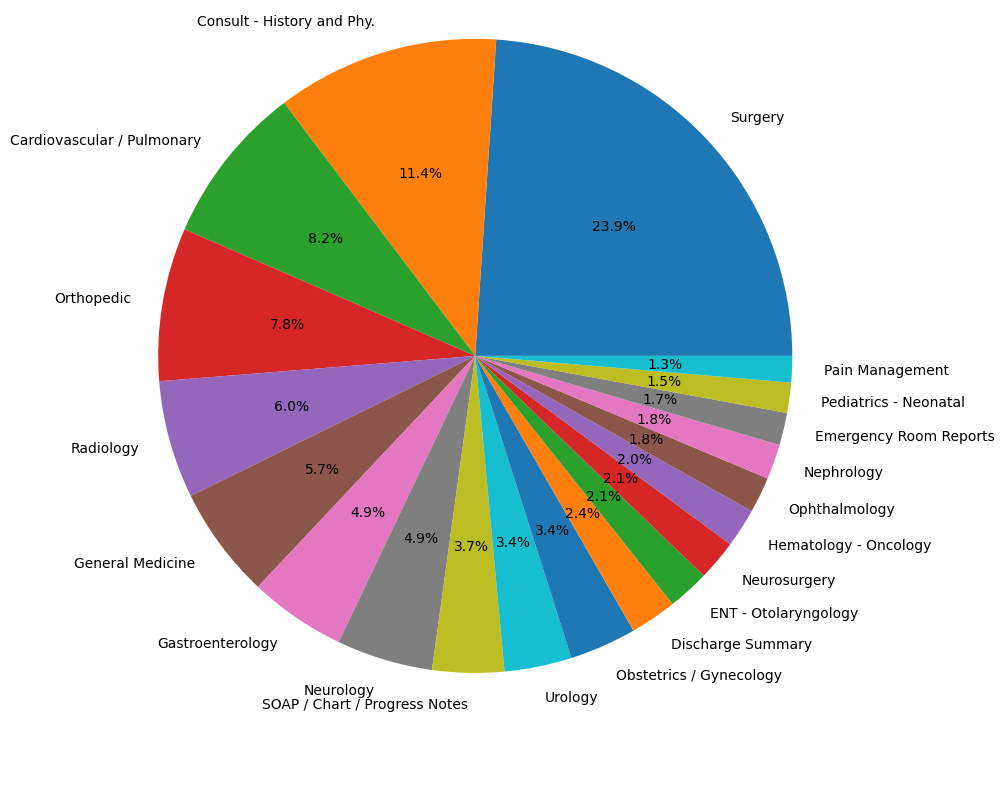

In [25]:
plt.figure(figsize=(9,9))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal');

In [26]:
general_categories_rows = full_data["medical_specialty"].isin(["Surgery", 'SOAP / Chart / Progress Notes', 'Office Notes', 'Consult - History and Phy.', 'Emergency Room Reports', 'Discharge Summary', 'Pain Management', 'General Medicine'])
data = full_data.drop(full_data[general_categories_rows].index)
data = data.reset_index(drop=True)

In [27]:
data["medical_specialty"] = data["medical_specialty"].str.replace("Neurosurgery", "Neurology")

In [28]:
data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,a 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"history of present illness: , i have seen abc ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-d m-mode. doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-d m-mode: , ,1. left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-d echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. the left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [29]:
data['medical_specialty'] = pd.Categorical(data['medical_specialty'])

In [30]:
data['medical_specialty'].cat.categories

Index(['Allergy / Immunology', 'Autopsy', 'Bariatrics',
       'Cardiovascular / Pulmonary', 'Chiropractic',
       'Cosmetic / Plastic Surgery', 'Dentistry', 'Dermatology',
       'Diets and Nutritions', 'ENT - Otolaryngology', 'Endocrinology',
       'Gastroenterology', 'Hematology - Oncology',
       'Hospice - Palliative Care', 'IME-QME-Work Comp etc.',
       'Lab Medicine - Pathology', 'Letters', 'Nephrology', 'Neurology',
       'Obstetrics / Gynecology', 'Ophthalmology', 'Orthopedic',
       'Pediatrics - Neonatal', 'Physical Medicine - Rehab', 'Podiatry',
       'Psychiatry / Psychology', 'Radiology', 'Rheumatology',
       'Sleep Medicine', 'Speech - Language', 'Urology'],
      dtype='object')

In [31]:
data['medical_specialty'].cat.codes

0       0
1       2
2       2
3       3
4       3
       ..
2638    0
2639    0
2640    0
2641    0
2642    0
Length: 2643, dtype: int8

In [32]:
data['labels'] = data['medical_specialty'].cat.codes
categories_mapping = dict(enumerate(data['medical_specialty'].cat.categories))

In [33]:
data[data["medical_specialty"].isin(data['medical_specialty'].value_counts()[5:].keys())]

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,labels
0,0,a 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",0
1,1,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",2
2,2,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"history of present illness: , i have seen abc ...","bariatrics, laparoscopic gastric bypass, heart...",2
5,5,morbid obesity. laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"preoperative diagnosis: , morbid obesity.,post...","bariatrics, gastric bypass, eea anastomosis, r...",2
6,6,"liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"preoperative diagnoses:,1. deformity, right b...","bariatrics, breast reconstruction, excess, lma...",2
...,...,...,...,...,...,...,...
2638,4994,patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"history:, i had the pleasure of meeting and e...",NaN,0
2639,4995,this is a 14-month-old baby boy caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"admitting diagnosis: , kawasaki disease.,disch...","allergy / immunology, mucous membranes, conjun...",0
2640,4996,a female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"subjective: , this is a 42-year-old white fema...",NaN,0
2641,4997,mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"chief complaint: , this 5-year-old male presen...",NaN,0


In [34]:
top_categories_num = 5
cause_dist = data['medical_specialty'].value_counts()[0:top_categories_num]
cause_dist_unseen_cat = data['medical_specialty'].value_counts()[top_categories_num:]
test_unseen_categories = data[data["medical_specialty"].isin(cause_dist_unseen_cat.keys())]
test_unseen_categories = test_unseen_categories.reset_index(drop=True)

In [35]:
unseen_categories_groups = test_unseen_categories.groupby(test_unseen_categories['medical_specialty'])
test_unseen_categories = unseen_categories_groups.filter(lambda x:x.shape[0] > 50)
unseen_categories_mapping = dict(enumerate(test_unseen_categories['medical_specialty'].cat.categories))
data = data[data["medical_specialty"].isin(cause_dist.keys())]
data = data.reset_index(drop=True)

In [36]:
cause_dist = data['medical_specialty'].value_counts()[0:top_categories_num]
print(cause_dist)

Cardiovascular / Pulmonary    371
Orthopedic                    355
Neurology                     317
Radiology                     273
Gastroenterology              224
Name: medical_specialty, dtype: int64


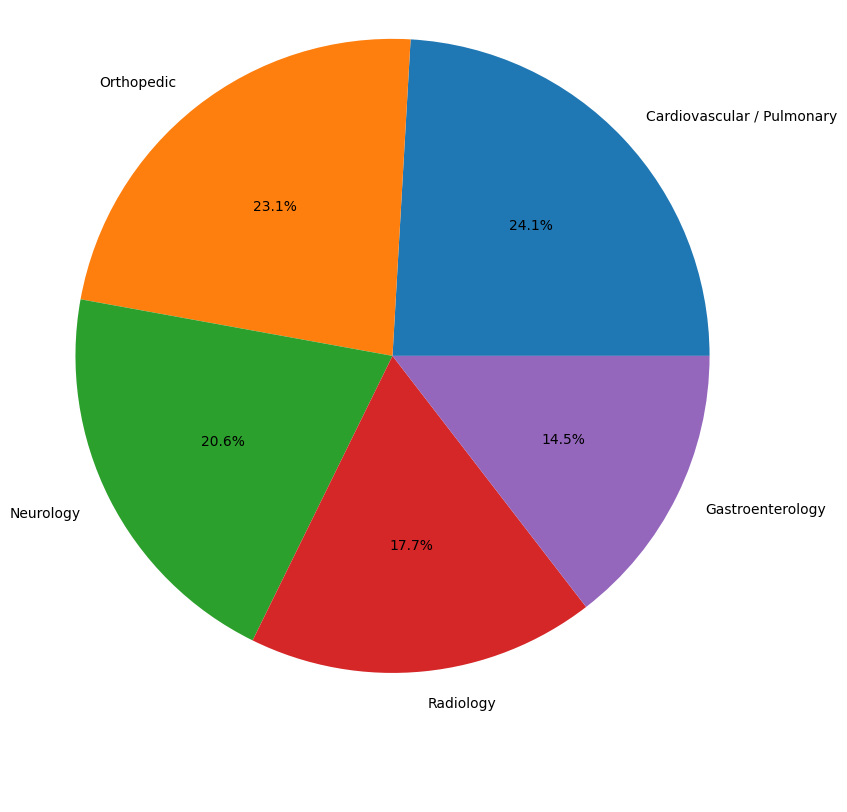

In [37]:
plt.figure(figsize=(9,9))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal');

In [38]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['description'], data['labels'], random_state=RAND, test_size=0.3, stratify=data['labels'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=RAND, test_size=0.5, stratify=temp_labels)
unseen_train_text, unseen_test_text, unseen_train_labels, unseen_test_labels = train_test_split(test_unseen_categories['description'], test_unseen_categories['labels'], random_state=RAND, test_size=0.2, stratify=test_unseen_categories['labels'])

In [39]:
model_name = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext' 
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [41]:
MAX_SENTENCE_LENGTH = 70 

In [42]:
texts = [train_text, val_text, test_text, unseen_train_text, unseen_test_text]
tokens_texts = []

for text in texts:
    tokens_texts.append(tokenizer.batch_encode_plus(text.tolist(), max_length = MAX_SENTENCE_LENGTH,
                                                    padding='max_length', truncation=True))

In [43]:
train_tokinized, val_tokinized, test_tokinized, unseen_train_tokinized, unseen_test_tokinized = tokens_texts

In [44]:
train_text.tolist()[0]

' bilateral lower extremity ultrasound for deep venous thrombus.'